In [2]:
home = "/home/ubuntu"

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import os
import pandas as pd
import collections
import torch.utils.data as data_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
%cd $home/FIGA/

/home/ubuntu/FIGA


In [ ]:
!gdown 1nzxq-AglpaPuIN90JY3zTW_wf4CcZhJR

Downloading...
From: https://drive.google.com/uc?id=1nzxq-AglpaPuIN90JY3zTW_wf4CcZhJR
To: /home/ubuntu/FIGA/dataset_full_new.csv
100%|███████████████████████████████████████| 84.7M/84.7M [00:00<00:00, 131MB/s]


In [2]:
torch.__version__

'1.10.0a0+gitb488e78'

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_layers = nn.Sequential(
                        nn.Linear(111,50),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(50,200),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(200,100),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(100,20),
                        nn.ReLU(),
                        nn.Dropout(p=0.8),
                        nn.Linear(20,10),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.linear_layers(x)
        return x

In [6]:
model = Net()
#model.load_state_dict(torch.load("/content/drive/MyDrive/FIGA/model_FIGA_trained.pt"))

###Original Dataset and model training

In [65]:
# Reading Original Dataset
data = pd.read_csv(home+'/FIGA/dataset_full.csv')

In [66]:
data = data.sample(frac=1).reset_index(drop=True)
data

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.564355,0,63949,6684,985,1,5,2,21599,0,0,0,0,0,0
1,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,37,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,33,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0.253577,0,395082,-1,-1,1,7,1,10799,0,0,0,0,0,1
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,28,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1.905697,0,28299,7548,-1,1,6,2,3591,0,1,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,17,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.508409,0,6939,7752,281,1,2,1,38389,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,28,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.537179,0,6939,-1,-1,1,2,1,14361,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,57,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,36,0,0,...,0,0,0,10,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.309043,0,47583,-1,-1,1,1,1,51,1,0,0,0,0,1
88643,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.258456,0,18650,6693,611,1,2,1,1769,1,0,0,0,0,0
88644,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,20,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.495230,0,16125,5650,193,1,2,0,599,0,0,0,0,0,0
88645,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.415314,0,26496,4259,123,1,2,0,591,0,0,0,0,0,0


In [67]:
#Scaling the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

df_scaled

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154490,0.0,2.035299,0.566314,2.301408,0.0,1.5,1.0,1.862745,-1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,1.875,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,-0.336116,0.0,17.374763,-0.474315,-0.476056,0.0,2.5,0.0,0.834761,-1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.666667,1.250,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.271984,0.0,0.383842,0.700809,-0.476056,0.0,2.0,1.0,0.148677,-1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.238095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066172,0.0,-0.605642,0.732565,0.318310,0.0,0.0,0.0,3.460879,-1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.666667,1.250,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111589,0.0,-0.605642,-0.474315,-0.476056,0.0,0.0,0.0,1.173805,-1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,1.0,1.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.250,0.0,0.0,...,1.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.248555,0.0,1.277158,-0.474315,-0.476056,0.0,-0.5,0.0,-0.188273,0.0,0.0,0.0,0.0,0.0,1.0
88643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [68]:
#Changing Target label type from float(Caused by scaling) to int
df_scaled['phishing'] = df_scaled['phishing'].astype(int)

In [69]:
train_data = df_scaled.iloc[:int(88647*0.8)]
val_data = df_scaled.iloc[int(88647*0.8):int(88647*0.8)+int(11055*0.1)]
test_data = df_scaled.iloc[int(88647*0.8)+int(88647*0.1):]

In [72]:
#Creating Dataloaders
train_target = torch.from_numpy(train_data['phishing'].values)
train = torch.from_numpy(train_data.drop('phishing', axis = 1).values,).float()
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True, pin_memory=True)

train_target = torch.from_numpy(val_data['phishing'].values)
train = torch.from_numpy(val_data.drop('phishing', axis = 1).values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
valid_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

train_target = torch.from_numpy(test_data['phishing'].values)
train = torch.from_numpy(test_data.drop('phishing', axis = 1).values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
test_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

In [8]:
device = torch.device("hpu")

In [10]:
model = Net()
model.to(device)

Net(
  (linear_layers): Sequential(
    (0): Linear(in_features=111, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=200, out_features=100, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=100, out_features=20, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.8, inplace=False)
    (12): Linear(in_features=20, out_features=10, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.4, inplace=False)
    (15): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [19]:
from habana_frameworks.torch.utils.library_loader import load_habana_module
import habana_frameworks.torch.core as htcore
load_habana_module()
def permute_params(model, to_filters_last, lazy_mode):
    import habana_frameworks.torch.core as htcore
    if htcore.is_enabled_weight_permute_pass() is True:
        return
    with torch.no_grad():
        for name, param in model.named_parameters():
            if(param.ndim == 4):
                if to_filters_last:
                    param.data = param.data.permute((2, 3, 1, 0))
                else:
                    param.data = param.data.permute((3, 2, 0, 1))  # permute RSCK to KCRS
    if lazy_mode:
        import habana_frameworks.torch.core as htcore
        htcore.mark_step()

def permute_momentum(optimizer, to_filters_last, lazy_mode):
    # Permute the momentum buffer before using for checkpoint
    import habana_frameworks.torch.core as htcore
    if htcore.is_enabled_weight_permute_pass() is True:
        return
    for group in optimizer.param_groups:
        for p in group['params']:
            param_state = optimizer.state[p]
            if 'momentum_buffer' in param_state:
                buf = param_state['momentum_buffer']
                if(buf.ndim == 4):
                    if to_filters_last:
                        buf = buf.permute((2,3,1,0))
                    else:
                        buf = buf.permute((3,2,0,1))
                    param_state['momentum_buffer'] = buf

    if lazy_mode:
        import habana_frameworks.torch.core as htcore
        htcore.mark_step()


Loading Habana modules from /home/ubuntu/.local/lib/python3.8/site-packages/habana_frameworks/torch/lib


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer  = optim.SGD(model.parameters(),lr = 0.1)
scheduler = StepLR(optimizer, step_size=8, gamma=0.35) #Learning Rate Scheduler

In [ ]:
# Load previous model if any
# model.load_state_dict(torch.load(home+"/FIGA/model_normal.pt"))

<All keys matched successfully>

In [20]:
permute_params(model, True, True)
permute_momentum(optimizer, True, True)

In [78]:
#TRAINING
epochs = 40 # Number of epochs
steps = 0
print_every = 100
train_losses, valid_losses,valid_acc = [], [], [] # List keeping track of losses and accuracy to plot later
valid_loss_min = np.Inf # It will be used to save model whenever Vallidation loss decreases
valid_acc_min = 0.0 

for e in range(epochs):
  
  train_loss = 0 
  model.train()
  #train the model
  for data, labels in train_loader:
    steps+=1
    # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
    data, labels = data.to(device), labels.to(device)
    # Clearing all the previous gradients
    optimizer.zero_grad()
    # Forward Pass
    logits = model(data)
    # Loss calculation
    loss = criterion(logits,labels)
    # Backward Pass
    loss.backward()
    # Update the parameters
    htcore.mark_step()
    optimizer.step()
    #htcore.mark_step()
    # Updating the losses list
    train_loss += loss.item()

    # Evaluating after specific amount of steps
    if steps % print_every == 0:
      valid_loss = 0
      accuracy = 0
      # Setting Model to Evaluation Mode
      model.eval()
      with torch.no_grad():
        # Getting Validation loss
        for data, labels in valid_loader:
          data, labels = data.to(device), labels.to(device)
          logits = model(data)
          batch_loss = criterion(logits,labels)
          valid_loss += batch_loss.item()
          
          # Calculating Accuracy
          output = F.softmax(logits,dim=1)
          top_p,top_class = output.topk(1,dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      # Printing stats    
      print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                  f"LR : {scheduler.get_lr():}"
                  )
      valid_loss = valid_loss/len(valid_loader)
      train_losses.append(train_loss/print_every)
      valid_losses.append(valid_loss)
      valid_acc.append(accuracy/len(valid_loader))
      
      # Checking if Validation loss decreased
      if valid_loss <= valid_loss_min:
        
        # if decreased, it will save the model
        print('valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.cpu().state_dict(), 'model.pt')
        model.to(device)
        valid_loss_min = valid_loss
      
    train_loss = 0    
  # Scheduler performing a step to change learning rate of Optimizer    
  scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 1/40.. Train loss: 0.004.. Validation loss: 0.367.. Validation accuracy: 0.860.. LR : [0.1]
valid loss decreased (inf --> 0.367133).  Saving model ...
Epoch 1/40.. Train loss: 0.003.. Validation loss: 0.266.. Validation accuracy: 0.890.. LR : [0.1]
valid loss decreased (0.367133 --> 0.266193).  Saving model ...
Epoch 1/40.. Train loss: 0.003.. Validation loss: 0.241.. Validation accuracy: 0.904.. LR : [0.1]
valid loss decreased (0.266193 --> 0.241066).  Saving model ...
Epoch 1/40.. Train loss: 0.002.. Validation loss: 0.217.. Validation accuracy: 0.913.. LR : [0.1]
valid loss decreased (0.241066 --> 0.217287).  Saving model ...
Epoch 1/40.. Train loss: 0.002.. Validation loss: 0.219.. Validation accuracy: 0.916.. LR : [0.1]
Epoch 2/40.. Train loss: 0.005.. Validation loss: 0.232.. Validation accuracy: 0.911.. LR : [0.1]
Epoch 2/40.. Train loss: 0.002.. Validation loss: 0.203.. Validation accuracy: 0.921.. LR : [0.1]
valid loss decreased (0.217287 --> 0.203286).  Saving model ...

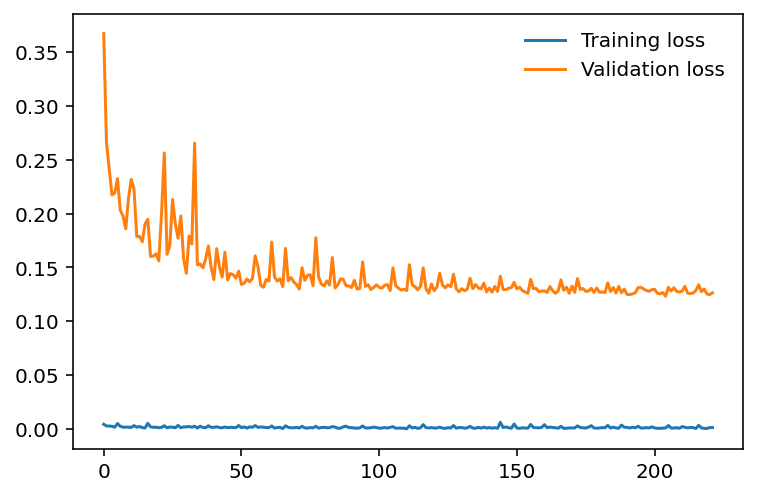

In [79]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

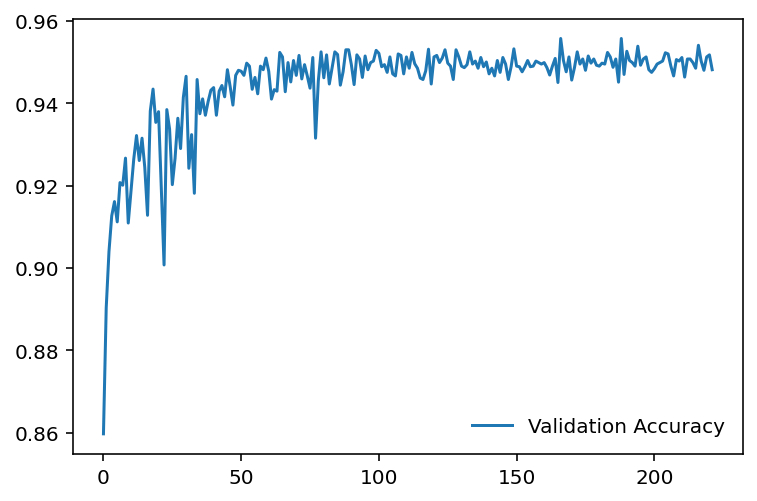

In [80]:
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(frameon=False)

In [81]:
torch.save(model.state_dict(), home+'/FIGA/model_normal.pt')

In [82]:
model.load_state_dict(torch.load(home+"/FIGA/model_normal.pt"))

<All keys matched successfully>

In [83]:
#To measure accuracy

def measure_accuracy(test_loader):
  model.eval() # Prep model for Evaluation
  correct_total = 0.
  total = 0.

  mean_of = 5 # Mean of how many evaluations
  valid_loss = 0.0

  for i in range(mean_of):
    for data, target in test_loader:
      # Move the data to device
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # update test loss 
      valid_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      for i in range(len(target)):
        if len(target) == 1:
          correct_total += correct.item()
        else:
          correct_total += correct[i].item()
        total += 1

  # calculate and print average test loss
  valid_loss = valid_loss/(mean_of * len(test_loader.dataset))
  print('Test Loss: {:.6f}\n'.format(valid_loss))


  #print total accuracy of the model
  print('Test Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
      (correct_total/total)*100,
      np.sum(correct_total), np.sum(total)))

In [84]:
#Normal Samples Accuracy (test_loader is the loader from original data)
measure_accuracy(test_loader)

Test Loss: 0.118334

Test Accuracy (Overall): 95.74% (42440/44330)


In [32]:
#FIGA IMPLEMENTATION

def check_sign(phis, legi, feature_no):
    '''
    phis - Phishing Site Data
    legi - Legitimate Site Data
    feature_no - The feature for which sign needs to be checked
    '''
    if (phis.iloc[:,feature_no].mean() - legi.iloc[:,feature_no].mean())>=0:
        return -1
    else:
        return 1

def featureImportance(X, y, n):
    '''
    X - Data
    y - Labels
    n - The number of features to perturb
    '''
    dtc = DecisionTreeClassifier()
    dtc.fit(X, y)
    importance = dtc.feature_importances_
    df_impor = pd.DataFrame({'Feature':np.arange(0,importance.size), 'Importance':importance},columns=['Feature', 'Importance'])
    df_impor.sort_values(by=['Importance'], ascending=False,inplace=True)
    f = df_impor.iloc[:n,0]
    phis = X[y==1]
    legi = X[y==0]
    d = [check_sign(phis, legi, x) for x in f]
    scaler = MinMaxScaler()
    scaler.fit(X.values)
    return f.to_numpy(), d, scaler
    
def perturbation(f, d, x, scaler, e = 0.05):
    '''
    X - Data
    f - feature_importance; A ranked feature vector
    d - Signed attack direction vector
    x - Sample to be perturbated
    scaler - Scaler used to transform values
    e - The total percentage of the input to modify
    '''
    sample = x
    sample = scaler.transform(sample.reshape(1, -1))
    E = e*np.sum(sample)/f.size
    for i in range(f.size):
        temp = sample[0][f[i]] + (E*d[i])
        if temp<0:
            temp = 0
        sample[0][f[i]] = temp
    sample = scaler.inverse_transform(sample)
    return np.round_(sample)

In [33]:
#Perturbating Samples
test_data_new = test_data
X, y = test_data_new.drop('phishing',axis =1 ), test_data_new['phishing']
f, d, scaler = featureImportance(X, y, 40)
for i in range(test_data_new.shape[0]):
  if test_data_new.iloc[i,111] == 1:
    X.iloc[i,:] = perturbation( f, d, X.iloc[i,:].to_numpy(), scaler, e=0.5).ravel()

In [34]:
#Creating Dataloader of Perturbated samples 
train_target = torch.from_numpy(y.values)
train = torch.from_numpy(X.values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
test_loader_new = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

In [35]:
#Perturbated Samples Accuracy (test_loader_new is the loader from Perturbated data)
measure_accuracy(test_loader_new)

Test Loss: 17.582987

Test Accuracy (Overall): 65.53% (29050/44330)


##FIGA

###FIGA Implementation

In [ ]:
#FIGA IMPLEMENTATION

def check_sign(phis, legi, feature_no):
    '''
    phis - Phishing Site Data
    legi - Legitimate Site Data
    feature_no - The feature for which sign needs to be checked
    '''
    if (phis.iloc[:,feature_no].mean() - legi.iloc[:,feature_no].mean())>=0:
        return -1
    else:
        return 1

def featureImportance(X, y, n):
    '''
    X - Data
    y - Labels
    n - The number of features to perturb
    '''
    dtc = DecisionTreeClassifier()
    dtc.fit(X, y)
    importance = dtc.feature_importances_
    df_impor = pd.DataFrame({'Feature':np.arange(0,importance.size), 'Importance':importance},columns=['Feature', 'Importance'])
    df_impor.sort_values(by=['Importance'], ascending=False,inplace=True)
    f = df_impor.iloc[:n,0]
    phis = X[y==1]
    legi = X[y==0]
    d = [check_sign(phis, legi, x) for x in f]
    scaler = MinMaxScaler()
    scaler.fit(X.values)
    return f.to_numpy(), d, scaler
    
def perturbation(f, d, x, scaler, e = 0.05):
    '''
    X - Data
    f - feature_importance; A ranked feature vector
    d - Signed attack direction vector
    x - Sample to be perturbated
    scaler - Scaler used to transform values
    e - The total percentage of the input to modify
    '''
    sample = x
    sample = scaler.transform(sample.reshape(1, -1))
    E = e*np.sum(sample)/f.size
    for i in range(f.size):
        temp = sample[0][f[i]] + (E*d[i])
        if temp<0:
            temp = 0
        sample[0][f[i]] = temp
    sample = scaler.inverse_transform(sample)
    return np.round_(sample)

###Training Model with perturbated dataset

In [107]:
%cd $home/FIGA

/content/drive/MyDrive/FIGA2


In [110]:
#Creating new dataset with perturbated samples with different combinations of n and e
from tqdm import tqdm
data = pd.read_csv(home+"/FIGA/dataset_full.csv")
total_data = data
for n_f, e in [(20,0.2),(15, 0.7),(25,0.1),(5,0.05),(10,0.02)]:
  data_to_perturb = data
  data_to_perturb = data.sample(frac=1).reset_index(drop=True)
  data_to_perturb = data_to_perturb.iloc[:int(data.shape[0]*0.3),:]
  X, y = data_to_perturb.drop('phishing', axis = 1 ), data_to_perturb['phishing']
  f, d, scaler = featureImportance(X, y , n_f)
  for i in tqdm(range(X.shape[0])):
    if y.iloc[i] == 1:
      X.iloc[i,:] = perturbation( f, d, X.iloc[i,:].to_numpy(), scaler, e).ravel()
  X['phishing'] = y
  total_data = total_data.append(X)
  del data_to_perturb

100%|██████████| 26594/26594 [05:13<00:00, 84.96it/s] 


In [111]:
#Saving the new dataset
total_data.to_csv(home+'/FIGA2/dataset_full_new.csv',index=False)

In [112]:
total_data = pd.read_csv(home+"/FIGA2/dataset_full_new.csv", index_col=False)

In [113]:
total_data

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,17,0,0,...,0,0,0,7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.207316,0,60781,-1,-1,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,0,0,0,0,0,0,0,3,223,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,16,0,0,...,0,0,0,9,0,0,1,0,0,3,0,2,0,0,0,0,0,0,0,0,0,165,0,3,0,0.499566,-1,36024,579,150,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,14,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.935901,0,4766,-1,-1,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,81,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,19,0,0,...,0,0,0,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.410021,0,20454,-1,-1,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.410761,0,53831,6998,306,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221612,4,1,0,5,0,1,1,0,0,0,0,0,0,0,0,0,0,3,27,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,15,0,0,...,0,0,0,9,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,24,1,1,1,-0.000000,0,28733,3243,381,1,3,2,27553,1,0,0,0,0,1
221613,2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,16,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-0.000000,0,4057,333,102,1,4,5,16996,1,0,0,0,0,1
221614,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.320962,0,60781,6368,205,1,2,2,1689,1,1,0,0,0,0
221615,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,16,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1.000000,0,-1,704,25,1,4,2,3598,0,-1,0,0,0,0


In [114]:
dataset_length = total_data.shape[0]

In [115]:
#Scaling the new dataset
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(total_data.drop('phishing', axis = 1)), columns=total_data.drop('phishing', axis = 1).columns)

df_scaled['phishing'] = total_data['phishing']

In [116]:
#Saving Sampler Pickle File 
import pickle
scalerfile = home+'/FIGA/scaler.pkl'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [117]:
#Saving Model pickle file
import pickle
modelfile = home+'/FIGA/model_FIGA_Trained.pkl'
pickle.dump(model, open(modelfile, 'wb'))

In [118]:
#Loading Sampler and Model
import pickle
scalerfile = home+'/FIGA/scaler.pkl'
scaler = pickle.load(open(scalerfile, 'rb'))
modelfile = home+'/FIGA/model_FIGA_Trained.pkl'
model = pickle.load(open(modelfile, 'rb'))

In [119]:
#Scaling dataset using recently loading sampler
df_scaled = pd.DataFrame(scaler.fit_transform(total_data.drop('phishing', axis = 1)), columns=total_data.drop('phishing', axis = 1).columns)
df_scaled['phishing'] = total_data['phishing']

In [120]:
df_scaled

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.125,0.0,0.0,...,1.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.209351,0.0,1.685511,-0.639835,-0.421846,0.0,0.0,-1.0,-0.191844,-1.0,0.0,0.0,0.0,0.0,1
1,3.0,0.0,1.0,1.5,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,15.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.250,0.0,0.0,...,1.0,1.0,1.0,10.0,1.0,1.0,2.0,1.0,1.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,166.0,1.0,4.0,0.0,0.187129,-1.0,0.749943,-0.547566,-0.137476,0.0,0.0,0.0,0.421489,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.307692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.666667,-0.500,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779083,0.0,-0.431298,-0.639835,-0.421846,0.0,0.0,2.0,-0.213333,0.0,0.0,0.0,0.0,0.0,0
3,2.0,0.0,2.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.769231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.125,0.0,0.0,...,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065648,0.0,0.161552,-0.639835,-0.421846,0.0,0.0,-1.0,-0.234397,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066652,0.0,1.422871,0.473592,0.156309,0.0,0.0,0.0,0.000000,-1.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221612,2.0,1.0,0.0,2.5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.615385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.375,0.0,0.0,...,1.0,1.0,1.0,10.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0,2.0,2.0,1.0,-0.490607,0.0,0.474416,-0.123767,0.297552,0.0,0.5,1.0,1.699007,0.0,0.0,0.0,0.0,0.0,1
221613,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [121]:
a = torch.tensor(scaler.transform(np.array(total_data.iloc[4,:111]).reshape(1,-1)).ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  "X does not have valid feature names, but"


In [122]:
output = model(a.float().unsqueeze(0))
_, pred = torch.max(output, 1)
print(pred.item())

0


In [123]:
df_scaled.shape

(221617, 112)

In [124]:
#Creating DataLoader of the new dataset
train_data = df_scaled.iloc[:int(dataset_length*0.7)]
val_data = df_scaled.iloc[int(dataset_length*0.7):int(dataset_length*0.85)]
test_data = df_scaled.iloc[int(dataset_length*0.85):]

train_target = torch.from_numpy(train_data['phishing'].values)
train = torch.from_numpy(train_data.drop('phishing', axis = 1).values,).float()
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 512, shuffle = True)

train_target = torch.from_numpy(val_data['phishing'].values)
train = torch.from_numpy(val_data.drop('phishing', axis = 1).values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
valid_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 512, shuffle = True)

train_target = torch.from_numpy(test_data['phishing'].values)
train = torch.from_numpy(test_data.drop('phishing', axis = 1).values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
test_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 512, shuffle = True)

In [125]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_layers = nn.Sequential(
                        nn.Linear(111,50),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(50,200),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(200,100),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(100,20),
                        nn.ReLU(),
                        nn.Dropout(p=0.8),
                        nn.Linear(20,10),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.linear_layers(x)
        return x

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer  = optim.SGD(model.parameters(),lr = 0.1)
scheduler = StepLR(optimizer, step_size=8, gamma=0.35)

In [127]:
#TRAINING MODEL ON NEW DATASET

epochs = 40 # Number of epochs
steps = 0
print_every = 10 
train_losses, valid_losses,valid_acc = [], [], [] # List keeping track of losses and accuracy to plot later
valid_loss_min = np.Inf # It will be used to save model whenever Vallidation loss decreases
valid_acc_min = 0.0 

for e in range(epochs):
  
  train_loss = 0 
  model.train()
  #train the model
  for data, labels in train_loader:
    steps+=1
    # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
    data, labels = data.to(device), labels.to(device)
    # Clearing all the previous gradients
    optimizer.zero_grad()
    # Forward Pass
    logits = model(data)
    # Loss calculation
    loss = criterion(logits,labels)
    # Backward Pass
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item()

    # Evaluating after specific amount of steps
    if steps % print_every == 0:
      valid_loss = 0
      accuracy = 0
      # Setting Model to Evaluation Mode
      model.eval()
      with torch.no_grad():
        # Getting Validation loss
        for data, labels in valid_loader:
          data, labels = data.to(device), labels.to(device)
          logits = model(data)
          batch_loss = criterion(logits,labels)
          valid_loss += batch_loss.item()
          
          # Calculating Accuracy
          output = F.softmax(logits,dim=1)
          top_p,top_class = output.topk(1,dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      # Printing stats    
      print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                  f"LR : {scheduler.get_lr():}"
                  )
      valid_loss = valid_loss/len(valid_loader)
      train_losses.append(train_loss/print_every)
      valid_losses.append(valid_loss)
      valid_acc.append(accuracy/len(valid_loader))
      
      # Checking if Validation loss decreased
      if valid_loss <= valid_loss_min:
        
        # if decreased, it will save the model
        print('valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
      
    train_loss = 0    
  # Scheduler performing a step to change learning rate of Optimizer    
  scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 1/40.. Train loss: 0.069.. Validation loss: 0.676.. Validation accuracy: 0.659.. LR : [0.1]
valid loss decreased (inf --> 0.675920).  Saving model ...
Epoch 1/40.. Train loss: 0.065.. Validation loss: 0.647.. Validation accuracy: 0.659.. LR : [0.1]
valid loss decreased (0.675920 --> 0.646704).  Saving model ...
Epoch 1/40.. Train loss: 0.061.. Validation loss: 0.634.. Validation accuracy: 0.659.. LR : [0.1]
valid loss decreased (0.646704 --> 0.633835).  Saving model ...
Epoch 1/40.. Train loss: 0.064.. Validation loss: 0.620.. Validation accuracy: 0.660.. LR : [0.1]
valid loss decreased (0.633835 --> 0.620248).  Saving model ...
Epoch 1/40.. Train loss: 0.057.. Validation loss: 0.582.. Validation accuracy: 0.691.. LR : [0.1]
valid loss decreased (0.620248 --> 0.581658).  Saving model ...
Epoch 1/40.. Train loss: 0.046.. Validation loss: 0.519.. Validation accuracy: 0.722.. LR : [0.1]
valid loss decreased (0.581658 --> 0.518770).  Saving model ...
Epoch 1/40.. Train loss: 0.040.. 

In [ ]:
torch.save(model.state_dict(), home+'/FIGA/model_FIGA_trained.pt')
measure_accuracy(test_loader)

Test Loss: 0.226101

Test Accuracy (Overall): 91.15% (151500/166215)


###Testing Model trained with perturbated dataset on new n and e

In [95]:
#Creating a new test dataset with original perturbated values of original data with new n and e (n and e not seen by model)
for n_f, e in [(20,0.2),(30,0.4)]:
  print("\n",n_f,e,"\n")
  test_data_new = test_data.drop('phishing',axis = 1)
  test_data_labels = test_data['phishing']
  f, d, scaler = featureImportance(test_data_new, test_data_labels , n_f)
  for i in range(test_data_new.shape[0]):
    if test_data_labels.iloc[i]==1:
      test_data_new.iloc[i,:] = perturbation( f, d, test_data_new.iloc[i,:].to_numpy(), scaler, e).ravel()
    
  #making a testloader out of it
  train_target = torch.from_numpy(test_data_labels.values)
  train = torch.from_numpy(test_data_new.values).float()
  train_tensor = data_utils.TensorDataset(train, train_target) 
  test_loader_new = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)
    
  #Testing perturbation with new n and e on normal model
  model.load_state_dict(torch.load(home+"/FIGA/model_normal.pt",map_location=torch.device('cpu')))
  measure_accuracy(test_loader_new)

  #Testing perturbation with new n and e on Adversarially trained model
  model.load_state_dict(torch.load(home+"/FIGA/model_FIGA_trained.pt"))
  measure_accuracy(test_loader_new)
  print('---------------')


 20 0.2 

Test Loss: 1.528593

Test Accuracy (Overall): 65.27% (28935/44330)
Test Loss: 0.251680

Test Accuracy (Overall): 90.18% (39975/44330)
---------------

 30 0.4 

Test Loss: 1.731688

Test Accuracy (Overall): 63.43% (28120/44330)
Test Loss: 0.192264

Test Accuracy (Overall): 92.82% (41145/44330)
---------------


##Inference

In [4]:
import pickle
import torch
from torch import nn
import numpy as np
import pandas as pd
import collections

In [5]:
a = np.array([ 2.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  1.00000e+00,  1.40000e+01,  2.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        2.00000e+00,  1.40000e+01,  0.00000e+00,  0.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
        0.00000e+00,  6.91094e-01,  1.00000e+00,  1.52440e+04,
        7.09900e+03,  2.05000e+02,  1.00000e+00,  2.00000e+00,
        2.00000e+00,  3.58900e+03,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00])

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_layers = nn.Sequential(
                        nn.Linear(111,50),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(50,200),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(200,100),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(100,20),
                        nn.ReLU(),
                        nn.Dropout(p=0.8),
                        nn.Linear(20,10),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.linear_layers(x)
        return x


scalerfile = home+'/FIGA/scaler.pkl'
scaler = pickle.load(open(scalerfile, 'rb'))
modelfile = home+'/FIGA/model_FIGA_Trained.pkl'
model = pickle.load(open(modelfile, 'rb'))


In [8]:
a = torch.tensor(scaler.transform(a.reshape(1,-1)).ravel())

output = model(a.float().unsqueeze(0))
_, pred = torch.max(output, 1)
print(pred.item())

0


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
